<a href="https://colab.research.google.com/github/pablopsz/data_science/blob/main/Sistema_de_Recomenda%C3%A7%C3%A3o_de_Filmes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação de Filmes

Você já ouviu falar de uma tal empresa chamada Netflix? E o tal Spotify? Youtube? Claro que já! E sabe o que todas essas plataformas tem em comum? Um poderoso sistema de recomendação. Pare pra pensar, você continuaria utilizando a Netflix caso os filmes recomendados não fossem interessantes pra você? A plataforma não seria tão interessante, correto? Por isso essas grandes empresas investem pesado em seus sistemas de recomendação.

<p>
  <img src="https://tm.ibxk.com.br/2017/07/06/06160447948233.jpg?ims=1280x480">
</p>

Vamos ver nesse projeto, um exemplo de como montar e utilizar um sistema de recomendação simples e tentar entender um pouco mais seu mecanismo de funcionamento.

## Importar os Dados e Bibliotecas
---
Vamos começar instalando e importando as biliotecas necessárias para a realização desse projeto, além dos dados que serão utilizados.

In [33]:
!pip install fuzzywuzzy

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from sklearn.neighbors import NearestNeighbors

Vamos utilizar a biblioteca "pandas" para manipulação de dados, a biblioteca fuzzywuzzy para preprocessamento dos dados, o modelo "NearestNeighbors".

# Análise exploratória de dados
---
Agora, vamos importar nossos dados. Esses dados foram adquiridos através do Kaggle. Você pode ter acesso a esses dados através [desse]("https://www.kaggle.com/datasets/ashukr/movie-rating-data?select=ratings.csv") link.

In [35]:
# ler os dados dos filmes
df_movies = pd.read_csv('movies.csv', sep=',')

# ler os dados de avaliações dos filmes
df_ratings = pd.read_csv('ratings.csv', sep=',')

Vamos conhecer um pouco melhor nossos dados.


In [36]:
# função para ver algumas características dos datasets
def data_carac(df):
  print(f'Dimensões dos dataset: {df.shape}')
  print(f'Colunas do dataset: {list(df.columns)}\n')
  print(f'Linhas com dados faltantes: \n{df_ratings.isnull().any(axis=1).sum()}\n')
  print(f'\n5 Primeiras Linhas: \n{df.head()}')

Vejamos primeiramente o dataset "movies".

In [37]:
# características do dataset de filmes
data_carac(df_movies)

Dimensões dos dataset: (62423, 3)
Colunas do dataset: ['movieId', 'title', 'genres']

Linhas com dados faltantes: 
0


5 Primeiras Linhas: 
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


Então, nosso primeiro dataset possui 62.423 linhas e apenas 3 colunas:
- **movieId**: Identificador único de cada filme.
- **title**: Título referente ao filme.
- **genres**: Lista dos gêrenos do filme.

Vamos ver agora o dataset "ratings".

In [38]:
# características do dataset de avaliações
data_carac(df_ratings)

Dimensões dos dataset: (25000095, 4)
Colunas do dataset: ['userId', 'movieId', 'rating', 'timestamp']

Linhas com dados faltantes: 
0


5 Primeiras Linhas: 
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


Nosso segundo dataset possui 8.781.258 linhas e 4 colunas:
- **userId** - Identificador único de cada usuário.
- **movieId** - Identificador único de cada filme.
- **rating** - A nota referente a avaliação do usuário em relação ao filme.
- **timestamp** - Representa quando a avaliação foi feita.

Continuando nossa exploração de dados, vamos ver agora a distribuição dos dados
em cada dataset.

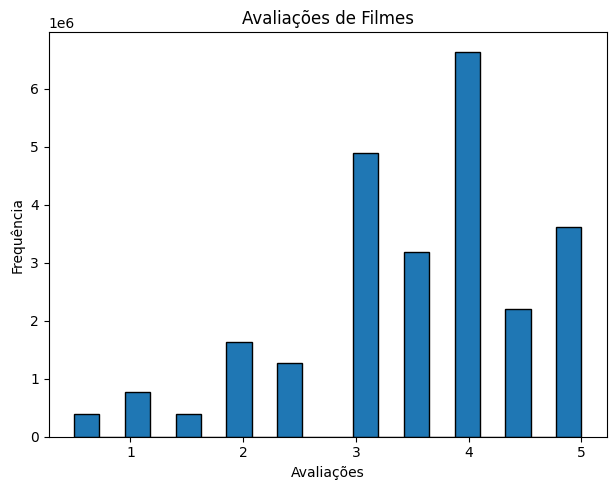

In [57]:
# Create a histogram of the 'rating' column in df_ratings
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_ratings['rating'], bins=20, edgecolor='black')
plt.xlabel('Avaliações')
plt.ylabel('Frequência')
plt.title('Avaliações de Filmes')

plt.tight_layout()
plt.show()

Podemos ver que as classificações estão bem distribuídas entre 3 e 5 com uma maior concentração em 4. Vamos agora analisar a média de vezes em que usuários avaliaram filmes e filmes foram avaliados.

In [43]:
media_avaliacoes_usuario = df_ratings["userId"].value_counts().mean().round()
print(f'Média de avaliações por usuário: {media_avaliacoes_usuario}')

media_avaliacoes_filme = df_ratings["movieId"].value_counts().mean().round()
print(f'Média de avaliações por filme: {media_avaliacoes_filme}')

Média de avaliações por usuário: 154.0
Média de avaliações por filme: 423.0


## Preparação dos Dados
---

Agora que entendemos um pouco melhor como nossos dados estão distribuídos, vamos começar a transformar esses dados. Como vamos confeccionar um modelo de recomendação de filmes, é valido filtrar nosso df a fim de gerar dados mais confiáveis. Por isso calculamos as médias anteriores, vamos filtrar nossos dados se baseando nessas métricas.

In [58]:
# lista de ids de filmes que que aparecem mais vezes que a média
filtered_movie_ids = df_ratings['movieId'].value_counts()[df_ratings['movieId'].value_counts() > media_avaliacoes_filme].index

# lista de ids de usuários que que aparecem mais vezes que a média
filtered_user_ids = df_ratings['userId'].value_counts()[df_ratings['userId'].value_counts() > media_avaliacoes_usuario].index

# filtra os dados baseado na listas anteriores
df_ratings_filtered = df_ratings[df_ratings['movieId'].isin(filtered_movie_ids) & df_ratings['userId'].isin(filtered_user_ids)]

Vamos agora ver o shape do nosso dataframe filtrado.

In [45]:
print(f'Dimensões dos dataset: {df_ratings_filtered.shape}')

Dimensões dos dataset: (16389888, 4)


Vamos filtrar também nosso dataframe de filmes.

In [46]:
df_movies_filtered = df_movies[df_movies['movieId'].isin(filtered_movie_ids)]

print(f'Dimensões dos dataset: {df_movies_filtered.shape}')

Dimensões dos dataset: (5828, 3)


Podemos ver que temos um número de 1.567.462 linhas no nosso dataframe de avaliações e 4.112 linhas em nosso dataframe de filmes. Vamos agora levar a informação de título do filme para nossa coluna de avaliações, juntando os dois dataframes.

In [47]:
df = pd.merge(df_ratings_filtered, df_movies_filtered, how='left', left_on='movieId', right_on='movieId')

df.head()

,userId,movieId,rating,timestamp,title,genres
0,2,1,3.5,1141415820,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,62,0.5,1141417130,Mr. Holland's Opus (1995),Drama
2,2,110,5.0,1141416589,Braveheart (1995),Action|Drama|War
3,2,150,4.0,1141415790,Apollo 13 (1995),Adventure|Drama|IMAX
4,2,151,4.5,1141415643,Rob Roy (1995),Action|Drama|Romance|War


Como vimos anteriormente, temos 1.567.462 linhas em nosso dataframe e 4.112 filmes. O próximo passo do nosso projeto é transformar nosso df em uma pivot table, onde os usuários serão as colunas, os filmes serão os índices das linhas e os valores que preencherão a tabela serão as respectivas notas que cada usário deu para cada filme (valores faltantes serão preenchidos com 0).

In [48]:
df = df.pivot(index='movieId', columns='userId', values='rating').fillna(0)

Vamos ver as dimensões dessa nova tabela.

In [49]:
print(f'Dimensões da tabela: {df.shape}\n')
print(df.head())

Dimensões da tabela: (5828, 42539)

userId   2       3       4       8       9       12      13      18      \
movieId                                                                   
1           3.5     4.0     3.0     4.0     0.0     4.0     4.0     3.0   
2           0.0     0.0     0.0     0.0     5.0     2.0     0.0     0.0   
3           0.0     0.0     0.0     4.0     0.0     2.0     0.0     1.5   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0     0.0     0.0     0.0     0.0     0.0     4.0   

userId   19      23      ...  162512  162515  162516  162519  162521  162524  \
movieId                  ...                                                   
1           0.0     0.0  ...     4.0     2.5     4.5     5.0     4.0     4.5   
2           3.5     0.0  ...     3.5     0.0     2.5     2.0     0.0     0.0   
3           0.0     5.0  ...     3.5     0.0     0.5     0.0     0.0     0.0   
4           0.0     0.0  ...     0.0  

## Construção do Modelo
---

Como dito antes, agora nossa tabela possui como índice os IDs dos usuários e, como colunas, os IDs dos filmes. Essa transformação é necessária para que possamos treinar nosso modelo. Nesse projeto, vamos utilizar o modelo KNN (K-Nearest Neighbors).

In [50]:
# número de recomendações que teremos como retorno
n_recs = 5

# instanciar o modelo
knn_model = NearestNeighbors(n_neighbors=n_recs+1, metric='cosine', algorithm='brute', n_jobs=-1)

Agora que instanciamos nosso modelo, como funciona o modelo KNN? O algoritmo K-Nearest Neighbors (KNN) é um modelo de aprendizado supervisionado utilizado para problemas de classificação e regressão que utiliza o agrupamento de pontos individuais para realizar previsões. Basicamente, buscamos classificar um ponto baseado na sua distância em relação aos seus "vizinho". O "K" em Knn define quantos vizinhos serão verificados para definir a classificação de um ponto. Como vantagens do KNN, podemos definir que é um modelo de fácil implementação e é um modelo que se adapta bem a novos dados. Como desvantagens do modelo podemos citar a baixa escalabilidade pois não é um modelo tão performático e, para cada novo usuário ou filme a ser incluído no conjunto, uma grande quantidade de dados será gerada.

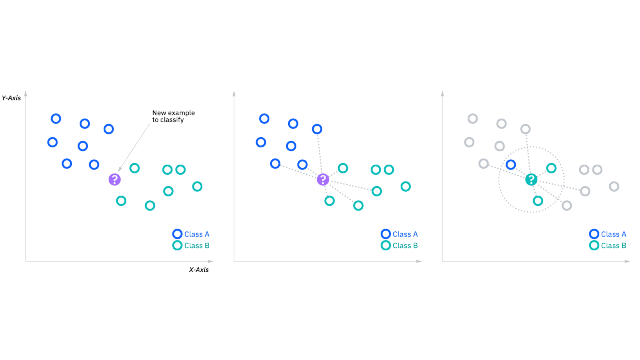

No modelo instanciado anteriormente, "n_recs" será o nosso "K" (número de vizinhos, que também será a quantidade de recomendações retornada pelo nosso modelo), "metric" será a métrica utilizada para avaliar a distância entre os pontos, nesse caso, utilizaremos a similaridade por cosseno. O parâmetro "algorithm" define qual algorítimo será utilizado para calcular a distãncia entre os pontos, utilizaremos força bruta nesse caso, o que pode prejudicar ainda mais a performance do modelo em casos com grandes quantidades de dados. Por último, o parâmetro "n_jobs" define o número de threads a serem usadas para o cálculo. Quando você define n_jobs=-1, você está indicando que o modelo deve usar todos os núcleos disponíveis do processador. Vamos agora treinar nosso modelo com nossa tabela.

In [51]:
# treinar o modelo
knn_model.fit(df)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=6)

Agora vamos definir algumas funções para utilizar nosso sistema de recomendação.

In [52]:
# retorna o título do filme baseado em seu id
def get_movie_title(movie_id):
    movie_title = df_movies_filtered[df_movies_filtered['movieId'] == movie_id]['title']
    if movie_title.empty:
        raise ValueError(f"Movie ID '{movie_id}' não encontrado.")
    return movie_title.values[0]

# tenta encontrar o valor que mais se aproxima do nome do título do filme buscado
def get_full_movie_title(title):
    full_title = process.extractOne(title, df_movies_filtered['title'])[0]
    print(full_title)
    return full_title

# retorna o id do filme baseado em seu título
def get_movie_id(title):
    movie_id = df_movies_filtered[df_movies_filtered['title'] == title]['movieId']
    if movie_id.empty:
        raise ValueError(f"Movie title '{title}' not found in the dataset.")
    return movie_id.values[0]

# busca os valores mais similares em relação ao valor buscado
def get_movie_recommendations(movie_title):
    try:
        movie_title = get_full_movie_title(movie_title)
        movie_id = get_movie_id(movie_title)
    except ValueError as e:
        print(e)
        return []

    # vizinhos mais próximos do título procurado
    distances, indices = knn_model.kneighbors(df.loc[movie_id].values.reshape(1, -1))

    recommendations = []

    for i in range(1, len(distances.flatten())):
        # retorna o título do filme
        movie_title = get_movie_title(df.index[indices.flatten()[i]])
        # retorna a distância
        distance = distances.flatten()[i]
        # adiciona o título e a distância à lista de recomendações
        recommendations.append((movie_title, distance))

    # cria um dataframe com as recomendações
    recommendations_df = pd.DataFrame(recommendations, columns=['Title', 'Distance'])

    return recommendations_df

Agora que já criamos nossas funções para utilizar o modelo de forma mais prática, vamos buscar recomendações de alguns filmes.

In [53]:
get_movie_recommendations('Shrek')

Shrek (2001)


,Title,Distance
0,"Lord of the Rings: The Fellowship of the Ring,...",0.210181
1,"Monsters, Inc. (2001)",0.217808
2,Finding Nemo (2003),0.226940
3,"Lord of the Rings: The Two Towers, The (2002)",0.232096
4,Pirates of the Caribbean: The Curse of the Bla...,0.243009


In [54]:
get_movie_recommendations('Fight Club')

Fight Club (1999)


,Title,Distance
0,"Matrix, The (1999)",0.184574
1,Pulp Fiction (1994),0.214041
2,Memento (2000),0.231156
3,"Lord of the Rings: The Fellowship of the Ring,...",0.235324
4,American Beauty (1999),0.236151


In [55]:
get_movie_recommendations('Shutter Island')

Shutter Island (2010)


,Title,Distance
0,Inception (2010),0.249723
1,Inglourious Basterds (2009),0.313960
2,Django Unchained (2012),0.329092
3,"Dark Knight, The (2008)",0.332519
4,"Dark Knight Rises, The (2012)",0.345810


In [56]:
get_movie_recommendations('The wolf of wall street')

Wolf of Wall Street, The (2013)


,Title,Distance
0,Django Unchained (2012),0.279897
1,Interstellar (2014),0.309679
2,Inception (2010),0.340919
3,"Dark Knight Rises, The (2012)",0.350431
4,Gone Girl (2014),0.352663


Certo, conseguimos as recomendações mas, o que elas significam? Significam que esses filmes são parecidos? Bom, não necessariamente. Quando procuramos vizinhos próximos nesse caso, o que temos como resultado são filmes que usuários gostam do título que procuramos também gostam. Por exemplo, quando olhamos para as recomendações do filme "Shrek", temos o filme "Procurando o Nemo" que possue algumas semelhanças com "Shrek" pois ambos são dos genêros animação e aventura. Quando olhamos as recomendações do filme "Ilha do medo" (Shutter Island), temos o filme "Matrix" (The Matrix). Quando pensamos por alto na semelhança entre os dois filmes, é complexo encontrar alguma similaridade. Porém (Alerta de spoiler, eu acho?), quando pensamos no conceito do filme "Ilha do medo" onde o protagonista vive uma realidade inventada por ele mesmo, conseguimos ver as semelhanças entre os filmes. Agora, quando olhamos as recomendações de "O lobo de Wall Street" (The Wolf of Wall Street), encontramos o filme "Interstellar". Então, eu pergunto, qual a semelhança entre os dois filmes? Talvez haja alguma mas, eu sinceramente não consigo imaginar nenhuma semelhança. Isso quer dizer que nosso sistema está quebrado. Não! Isso apenas quer dizer que pessoas que gostam de "O lobo de Wall Street" tendem a gostar de "Interstellar".

## Conclusão

Chegamos ao fim desse projeto. Aqui apresentei um sistema de recomendação simples mas não se enganem, grandes empresas com sistemas de recomendações possuem sistemas muito mais complexos levando em consideração diversas outras métricas, mas o foco do projeto era mostrar como montar um sistema de recomendação simples e entender o funcionamento desse mecanismo em específico, que, ainda que seja simples, pode acabar trazendo algumas soluções interessantes.